# Competition where metric is rmse of log of prices
[Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv)

In [70]:
# Set up code checking
# Set up filepaths
import os
os.chdir(os.path.join(os.path.expanduser('~'), 'kaggle'))

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data into dataframes

In [72]:
train_path = os.path.join('data', 'house-prices-advanced-regression', 'train.csv')
train_data = pd.read_csv(train_path)

test_path = os.path.join('data', 'house-prices-advanced-regression', 'test.csv')
test_data_original = pd.read_csv(test_path)

## 1.1 Identify numeric and categorical features 

In [73]:
y = np.log(train_data['SalePrice'])
train_data.drop(columns=['SalePrice', 'Id'], inplace=True)
test_data = test_data_original.drop(columns=['Id'])

# remove stupid columns
train_data.drop(columns=['LowQualFinSF'], inplace=True)
test_data.drop(columns=['LowQualFinSF'], inplace=True)

numerical_columns = train_data.select_dtypes(include=np.number).columns.tolist()

numerical_columns.remove('MSSubClass')

categorical_columns = [c for c in train_data.columns if c not in numerical_columns]

print(train_data.shape, test_data.shape)

(1460, 78) (1459, 78)


# 2. EDA

## 2.1 Create imputation pipeline, factorize categoric features 

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, OrdinalEncoder 
from category_encoders import TargetEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# class AddMissingIndicator(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.num_cols_with_na = [] 

#     def fit(self, X, y=None):
#         df = pd.DataFrame(X)
#         self.num_cols_with_na = [c for c in df.columns if df[c].isna().any()]
#         return self
    
#     def transform(self, X, y=None) -> pd.DataFrame:
#         df_to_transform = pd.DataFrame(X)
#         for c in self.num_cols_with_na:
#             missing_col_name = f"{c}_is_missing"
#             df_to_transform[missing_col_name] = np.where(X[c].isna(), 1, 0) 
        
#         return df_to_transform 


numeric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
])

categoric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('label_encoder', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=np.nan)),
])

# fills all missing values, but does not transform the data
imputing_transformer = ColumnTransformer(transformers=[
    ('numeric_imputer', numeric_imputer, numerical_columns),
    ('categoric_imputer', categoric_imputer, categorical_columns)
])

train_data_imputed = pd.DataFrame(
    imputing_transformer.fit_transform(train_data), 
    columns=numerical_columns + categorical_columns
)


## 2.2 Create new features 

In [75]:
# total area of house

train_data_imputed["LivingArea"] = train_data_imputed['1stFlrSF'] + train_data_imputed['2ndFlrSF'] 

# area per room, more is better
train_data_imputed["AreaPerRoom"] = train_data_imputed['LivingArea']/train_data_imputed['TotRmsAbvGrd']

train_data_imputed['OutsideArea'] = sum(train_data_imputed[i] for i in [
    'WoodDeckSF', 
    'OpenPorchSF', 
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch'
])

# ratio of area of house to area of the whole lot
train_data_imputed['LivLotRatio'] = train_data_imputed['LivingArea']/train_data_imputed['LotArea']

# update numeric columns to include the newly created features
numerical_columns = train_data_imputed.select_dtypes(include=np.number).columns.tolist()
print(numerical_columns)



['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',

## 2.3 Mutual info with target

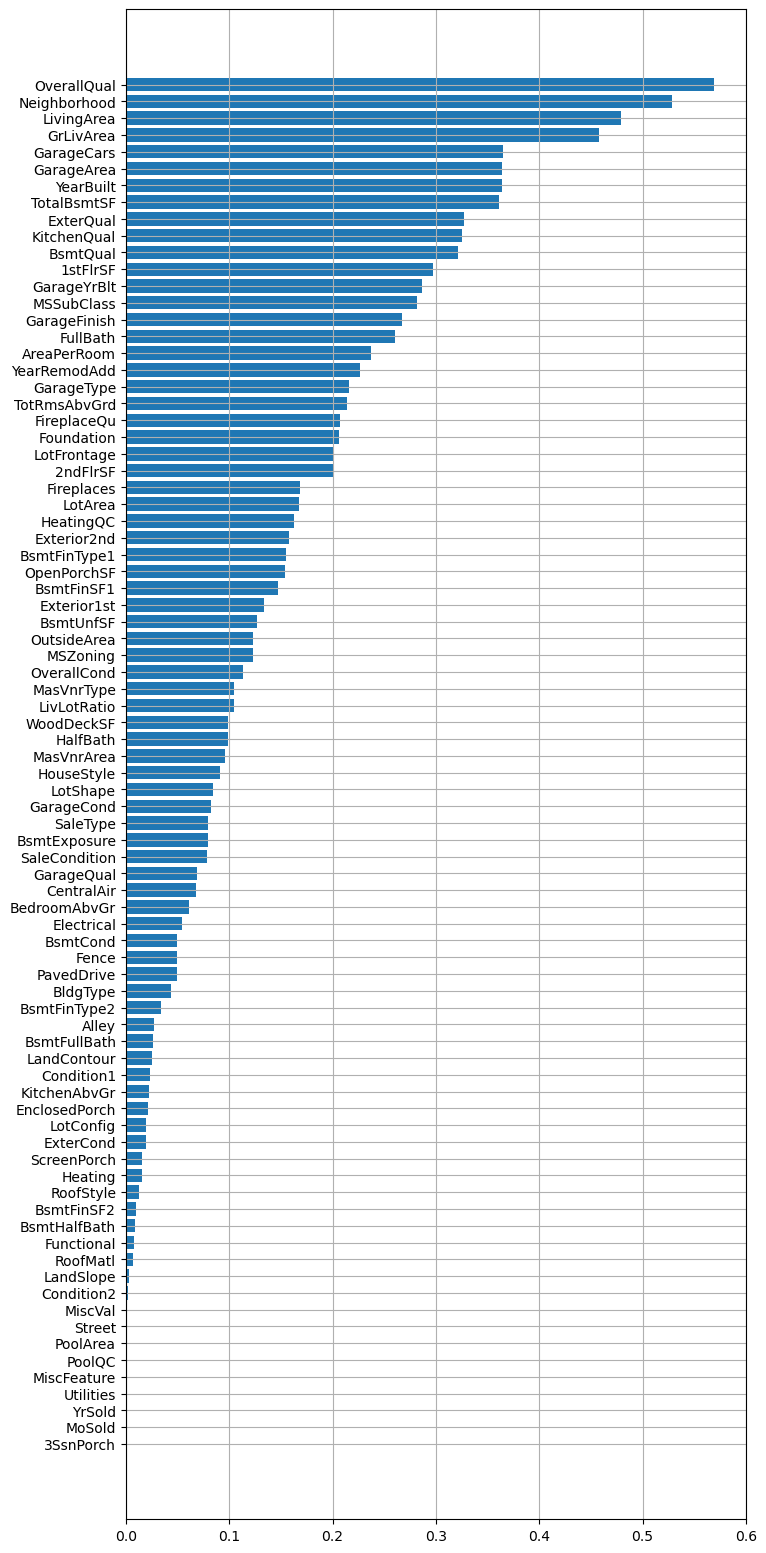

In [76]:
from sklearn.feature_selection import mutual_info_regression

discrete_features = [
    i for (i, c) in enumerate(train_data_imputed.columns) if c in categorical_columns
]
mi_scores = mutual_info_regression(train_data_imputed, y, discrete_features=discrete_features)

mi_scores = pd.Series(mi_scores, index=train_data_imputed.columns)
mi_scores = mi_scores.sort_values(ascending=True)

# plot mi scores
y_pos = np.arange(len(train_data_imputed.columns))

plt.figure(dpi=100, figsize=(8, 20))
plt.barh(y_pos, mi_scores)
plt.yticks(y_pos, labels=mi_scores.index)
plt.xticks(np.arange(min(mi_scores), max(mi_scores)*1.1, 0.1))
plt.grid()
plt.show()


## 2.4 Identify columns with roughly gaussian distributions 

In [77]:
# fig = train_data_imputed.hist(column=numerical_columns, figsize=(20, 20), rwidth=0.9)

gaussable_columns = [
    'LotFrontage',
    'OverallQual',
    'OverallCond',
    'TotalBsmtSF',
    '1stFlrSF', 
    '2ndFlrSF', 
    'GrLivArea',
    'BedroomAbvGr',
    'TotRmsAbvGrd',
    'GarageArea', 
    'LivingArea', 
    'AreaPerRoom',
    'OutsideArea',
    'LivLotRatio'
]

# 3. Transform dataset to prepare it for the models

## 3.1 Create smaller pipelines for preprocessing 

In [78]:
from category_encoders import TargetEncoder
# adds additional column which indicates whether data was missing for given feature

# for categorical columns with high cardinality
target_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)), # categories are encoded as nums
    ('target_encoding', TargetEncoder()) 
])

# for cat columns with low cardinality 
ohe_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)), 
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# small cardinality columns get OHE, large get target encoding
small_cardinality_cat_columns = [c for c in categorical_columns if len(set(train_data[c])) < 5]

large_cardinality_cat_columns = [c for c in categorical_columns if c not in small_cardinality_cat_columns]

normal_numeric_columns = [c for c in numerical_columns if c not in gaussable_columns]

standard_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

gauss_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('power_scaler', PowerTransformer())
])

preprocessing = ColumnTransformer(transformers=[
    ('normal_numerical', standard_num_pipeline, normal_numeric_columns),
    ('gauss_numerical', gauss_num_pipeline, gaussable_columns),
    ('target_categorical', target_cat_pipeline, large_cardinality_cat_columns), 
    ('OHE_categorical', ohe_cat_pipeline, small_cardinality_cat_columns), 
])

## 3.2 Test different regression models

In [86]:
from sklearn.linear_model import Lasso, Ridge, BayesianRidge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score


models = {
    'ridge': Ridge(),
    'lasso': Lasso(random_state=1),
    'xgboost': XGBRegressor(random_state=1, eval_metric='rmse'),
    # 'GBR': GradientBoostingRegressor(loss='squared_error', random_state=1),
    'lgbm': LGBMRegressor(), 
    'cat_boost': CatBoostRegressor(silent=True), 
    'b_ridge': BayesianRidge(), 
    'hist_gbr': HistGradientBoostingRegressor()
}

pipelines = {key: Pipeline(steps=[
    ('preprocessing', preprocessing),
    (f'{key}', models[key])
]) for key in models}

# models['cat_boost'] = CatBoostRegressor(silent=True)

# pipelines['cat_boost'] = Pipeline(steps=[
#     ('preprocessing_no_ohe', preprocessing_no_ohe), 
#     ('cat_boost', models['cat_boost'])
# ])

def get_rmse(predictor, X, y):
    return -cross_val_score(predictor, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()


for p in pipelines:
    predictor = pipelines[p]
    mae = get_rmse(predictor, train_data_imputed, y)
    print(f"Model: {p}")
    print(f'RMSE: {mae}')
    print()


Model: ridge
RMSE: 0.13862424034222778

Model: lasso
RMSE: 0.3992282792085989

Model: xgboost
RMSE: 0.14452206609613433

Model: lgbm
RMSE: 0.1342138976865473

Model: cat_boost
RMSE: 0.12097951716173219

Model: b_ridge
RMSE: 0.13950290630927148

Model: hist_gbr
RMSE: 0.134087274107066



## 3.3 Define param tuning functions 


In [94]:
import optuna
from copy import deepcopy

optuna.logging.set_verbosity(0)

def ridge_cost(trial):
    alpha = trial.suggest_loguniform('ridge__alpha', 10, 100)
    tol = trial.suggest_loguniform('ridge__tol', 1e-7, 1e-4)
    pipe = deepcopy(pipelines['ridge'])
    pipe.set_params(**{
        'ridge__alpha': alpha, 
        'ridge__tol': tol
    })
    return get_rmse(pipe, train_data_imputed, y)

def lasso_cost(trial):
    alpha = trial.suggest_loguniform('lasso__alpha', 1e-4, 1)
    tol = trial.suggest_loguniform('lasso__tol', 1e-5, 1e-3)
    pipe = deepcopy(pipelines['lasso'])
    pipe.set_params(**{
        'lasso__alpha': alpha, 
        # 'lasso__tol': tol
    })
    return get_rmse(pipe, train_data_imputed, y)

In [95]:
from optuna.integration import LightGBMPruningCallback

def xgboost_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['xgboost'])

    pipe.set_params(**{
        'xgboost__max_depth': trial.suggest_int('max_depth', 1, 4), 
        'xgboost__min_child_weight': trial.suggest_int('min_cw', 0, 10), 
        'xgboost__colsample_bytree': trial.suggest_float('cs_bt', 0, 1),
        'xgboost__n_estimators': trial.suggest_int('n_est', 50, 800), 
        'xgboost__reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'xgboost__subsample': trial.suggest_float('subsample', 0, 1), 
        'xgboost__reg_alpha': trial.suggest_float('alpha', 0, 1),
        'xgboost__eval_metric': 'rmse'
    })

    return get_rmse(pipe, train_data_imputed, y)


In [96]:
# def lgbm_cost(trial: optuna.trial.Trial):
#     pipe = deepcopy(pipelines['lgbm'])
#     pipe.set_params(**{
#         # "lgbm__num_iterations": trial.suggest_int('num_iterations', 50, 300),
#         "lgbm__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "lgbm__num_leaves": trial.suggest_int("num_leaves", 20, 300),
#         # "lgbm__max_depth": trial.suggest_int("max_depth", 3, 12),
#         "lgbm__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
#         # "lgbm__max_bin": trial.suggest_int("max_bin", 200, 300),
#         # "lgbm__lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         # "lgbm__lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "lgbm__min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         # "lgbm__bagging_fraction": trial.suggest_float(
#         #     "bagging_fraction", 0.2, 0.95
#         # ),
#         # "lgbm__bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         # "lgbm__feature_fraction": trial.suggest_float(
#         #     "feature_fraction", 0.5, 0.95
#         # ),
#         'lgbm__early_stopping_rounds': 100,
#         # 'lgbm__callbacks': [LightGBMPruningCallback(trial, 'rmse')]
#     })

#     return get_rmse(pipe, train_data, y)

In [97]:
def catboost_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['cat_boost'])
    pipe.set_params(**{
        "cat_boost__colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "cat_boost__depth": trial.suggest_int("depth", 4, 10),
        "cat_boost__boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "cat_boost__bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "cat_boost__eval_metric": "RMSE",
    })

    return get_rmse(pipe, train_data_imputed, y)

In [98]:
def b_ridge_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['b_ridge'])
    pipe.set_params(**{
        'b_ridge__n_iter': trial.suggest_int('n_iter', 100, 1000, log=True), 
        'b_ridge__alpha_1': trial.suggest_float('alpha1', 1e-9, 1e-3, log=True),
        'b_ridge__alpha_2': trial.suggest_float('alpha2', 1e-9, 1e-3, log=True),
    })

    return get_rmse(pipe, train_data_imputed, y)

In [99]:
def hist_gbr_cost(trial: optuna.trial.Trial):
    pipe = deepcopy(pipelines['hist_gbr'])
    pipe.set_params(**{
        'hist_gbr__max_iter': trial.suggest_int('max_iter', 50, 500),
        'hist_gbr__max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 5, 50), 
    })
    return get_rmse(pipe, train_data_imputed, y)

In [100]:

functions = {
    'ridge': ridge_cost, 
    'lasso': lasso_cost,
    'xgboost': xgboost_cost, 
    # 'lgbm': lgbm_cost,
    'cat_boost': catboost_cost,
    'b_ridge': b_ridge_cost,
    'hist_gbr': hist_gbr_cost,
}

for name in functions:
    study = optuna.create_study()
    study.optimize(functions[name], n_trials=30, show_progress_bar=True)
    print(f'Model {name}')
    print(f'Best params: {study.best_params}')
    print(f'Best score: {study.best_value}')
    print(optuna.importance.get_param_importances(study), '\n')


/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


Model ridge
Best params: {'ridge__alpha': 98.26018660797482, 'ridge__tol': 9.788680346975573e-06}
Best score: 0.13922412362025588


/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


OrderedDict([('ridge__alpha', 0.9994798019241887), ('ridge__tol', 0.0005201980758112294)]) 



 33%|███▎      | 10/30 [00:06<00:12,  1.60it/s]/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.573e+00, tolerance: 1.891e-02
  model = cd_fast.enet_coordinate_descent(
/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+00, tolerance: 1.800e-02
  model = cd_fast.enet_coordinate_descent(
/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Model lasso
Best params: {'lasso__alpha': 0.002748900873511109, 'lasso__tol': 9.974354348090254e-05}
Best score: 0.1379527010310997


/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


OrderedDict([('lasso__alpha', 0.7422827376462711), ('lasso__tol', 0.25771726235372894)]) 



100%|██████████| 30/30 [03:01<00:00,  6.05s/it]


Model xgboost
Best params: {'max_depth': 2, 'min_cw': 1, 'cs_bt': 0.30032723879729, 'n_est': 739, 'reg_lambda': 0.4395478592115192, 'subsample': 0.9343021941520818, 'alpha': 0.7979573279152375}
Best score: 0.12522569351001409


/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


OrderedDict([('subsample', 0.6844646108370026), ('reg_lambda', 0.14698905603177012), ('alpha', 0.07359215643917182), ('n_est', 0.05246029069812684), ('max_depth', 0.020584170831647153), ('min_cw', 0.017176405079243486), ('cs_bt', 0.004733310083037989)]) 



100%|██████████| 30/30 [05:14<00:00, 10.48s/it]


Model cat_boost
Best params: {'colsample_bylevel': 0.0763157049902472, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}
Best score: 0.12044094941119936


/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


OrderedDict([('colsample_bylevel', 0.5825031167945831), ('depth', 0.3705008852603636), ('bootstrap_type', 0.03682084144016767), ('boosting_type', 0.010175156504885588)]) 



100%|██████████| 30/30 [00:14<00:00,  2.01it/s]
/home/vasil/earth-analytics-parent/earth-analytics/conda-env/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


Model b_ridge
Best params: {'n_iter': 147, 'alpha1': 8.922734199769425e-08, 'alpha2': 0.0009786843769192207}
Best score: 0.13950282655278162
OrderedDict([('alpha2', 1.0), ('n_iter', 3.306773424375692e-20), ('alpha1', 0.0)]) 



100%|██████████| 30/30 [04:29<00:00,  8.98s/it]


Model hist_gbr
Best params: {'max_iter': 449, 'max_leaf_nodes': 6}
Best score: 0.1297006053717095
OrderedDict([('max_leaf_nodes', 0.5190220612546738), ('max_iter', 0.48097793874532624)]) 



In [75]:
from sklearn.ensemble import VotingRegressor
final_best_params = {}

final_best_params['lasso'] = {
    'lasso__alpha': 0.0027, 
    'lasso__tol': 1e-4 
}

final_best_params['ridge'] = {
    'ridge__alpha': 98,
    'ridge__tol': 9.943295651368705e-06
}

final_best_params['xgboost'] = {
    'xgboost__eval_metric': 'rmse', 
    # 'xgboost__max_depth': 2, 
    # 'xgboost__n_estimators': 418,
    # 'xgboost__min_child_weight': 1, 
    # 'xgboost__gamma': 0.0, 
    # 'xgboost__colsample_bytree': 0.16, 
    # 'xgboost__subsample': 0.78, 
    # 'xgboost__reg_alpha': 0.37,
    # 'xgboost__reg_lambda': 0.25

    # 'xgboost__max_depth': 2, 
    # 'xgboost__min_child_weight': 3, 
    # 'xgboost__colsample_bytree': 0.2049030222473224, 
    # 'xgboost__n_estimators': 479, 
    # 'xgboost__reg_lambda': 0.2824862837800328, 
    # 'xgboost__subsample': 0.9561978086541947, 
    # 'xgboost__alpha': 0.8384411117820882

    'xgboost__max_depth': 2, 
    'xgboost__min_cw': 1, 
    'xgboost__colsample_bytree': 0.30032723879729, 
    'xgboost__n_estimators': 739, 
    'xgboost__reg_lambda': 0.4395478592115192, 
    'xgboost__subsample': 0.9343021941520818, 
    'xgboost__alpha': 0.7979573279152375
}


# final_best_params['GBR'] = {
#     'GBR__loss': 'squared_error', 
#     'GBR__n_estimators': 380, 
#     'GBR__random_state': 1, 
#     'GBR__subsample': 1, 
#     'GBR__max_depth': 4, 
#     'GBR__min_samples_split': 8 
# }


final_best_params['lgbm'] = {}

final_best_params['cat_boost'] = {
    'cat_boost__colsample_bylevel': 0.0763157049902472, 
    'cat_boost__depth': 5, 
    'cat_boost__boosting_type': 'Plain', 
    'cat_boost__bootstrap_type': 'Bayesian'
} # no improvement over default params

final_best_params['b_ridge'] = {}

final_best_params['hist_gbr'] = {
    'hist_gbr__max_leaf_nodes': 5, 
    'hist_gbr__max_iter': 306
}

list_of_models = []
scores = []
for pipe_name in final_best_params:
    # set the corresponding model with the optimal parameters
    pipelines[pipe_name] = pipelines[pipe_name].set_params(**final_best_params[pipe_name])
    pipe = pipelines[pipe_name]
    list_of_models.append((pipe_name, pipe))
    rmse = get_rmse(pipe, train_data, y)
    scores.append(-rmse)
    print(f'Model {pipe_name}: rmse {rmse:.5f}')

weights = [min(scores)/score for score in scores]

final_estimator = VotingRegressor(list_of_models, weights=weights)
print(f'Ensemble model rmse: {get_rmse(final_estimator, train_data, y):.5f}')

Model xgboost: rmse 0.12474
Model ridge: rmse 0.12931
Model lgbm: rmse 0.13257
Model cat_boost: rmse 0.11898
Model b_ridge: rmse 0.12952
Model hist_gbr: rmse 0.12737
Ensemble model rmse: 0.11918


## Stacking model

In [76]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression


print([i for i in final_best_params])
all_estimators = [(name, pipelines[name]) for name in final_best_params]
stacked_model = StackingRegressor(estimators=all_estimators)

print('Stacked model')
print(f'RMSE: {get_rmse(stacked_model, train_data, y)}')

['xgboost', 'ridge', 'lgbm', 'cat_boost', 'b_ridge', 'hist_gbr']
Stacked model
RMSE: 0.11984498936945749


## Generate final submission 

In [14]:
final_predictions = stacked_model.fit(train_data, y).predict(test_data)
print(np.exp(final_predictions).shape, test_data_original['Id'].shape)
output = pd.DataFrame({'Id': test_data_original.Id,
                    'SalePrice': np.exp(final_predictions)})
output.to_csv(f'code/house-prices-advanced-regression/big_ensemble_model_2.csv', index=False)

(1459,) (1459,)
